In [13]:
import torch
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate Swiss Roll data
n_samples = 1000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
X = X[:, [0, 2]]  # We only want 2D projection
X = torch.FloatTensor(X)

# Normalize the data
X = (X - X.mean(dim=0)) / X.std(dim=0)

class GaussianMixture(torch.nn.Module):
    def __init__(self, n_components, n_dimensions=2):
        super().__init__()
        
        # Initialize means randomly
        self.means = torch.nn.Parameter(torch.randn(n_components, n_dimensions))
        
        # Initialize log variances
        self.log_vars = torch.nn.Parameter(torch.zeros(n_components, n_dimensions))
        
        # Initialize mixing coefficients
        self.mixing_logits = torch.nn.Parameter(torch.zeros(n_components))
    
    def get_mixture_distribution(self):
        # Convert log variances to covariance matrices
        vars = torch.exp(self.log_vars)
        covs = torch.stack([torch.diag(var) for var in vars])
        
        # Create list of multivariate normals
        components = [MultivariateNormal(mean, cov) for mean, cov in zip(self.means, covs)]
        
        # Get mixing coefficients
        mixing_coeffs = torch.softmax(self.mixing_logits, dim=0)
        
        return components, mixing_coeffs
    
    def forward(self, X):
        components, mixing_coeffs = self.get_mixture_distribution()
        
        # Calculate likelihood for each component
        component_likelihoods = torch.stack([comp.log_prob(X) for comp in components])
        
        # Add mixing coefficients and compute log-sum-exp
        logits = component_likelihoods + torch.log(mixing_coeffs.unsqueeze(1))
        log_prob = torch.logsumexp(logits, dim=0)
        
        return log_prob.mean()

    def reconstruct(self, X):
        # first, get the most likely component for each point
        components, mixing_coeffs = self.get_mixture_distribution()
        component_likelihoods = torch.stack([comp.log_prob(X) for comp in components])
        logits = component_likelihoods + torch.log(mixing_coeffs.unsqueeze(1))
        most_likely_component = torch.argmax(logits, dim=0)
        # then, reconstruct each point using the most likely component
        most_likely_component = most_likely_component.long()
        recon_data = torch.stack([components[i].mean for i in most_likely_component])
        # add noise to the reconstructed data according to the variance of the most likely component
        # Get variances for each point based on its most likely component
        variances = torch.stack([components[i].variance for i in most_likely_component])
        recon_data = recon_data + torch.randn_like(recon_data) * torch.sqrt(variances)
        return recon_data
    
    def sample(self, n_samples):
        # first, sample the most likely component for each point
        components, mixing_coeffs = self.get_mixture_distribution()
        # component_likelihoods = torch.stack([comp.log_prob(X) for comp in components])
        # Sample component indices according to mixing coefficients
        component_idx = torch.multinomial(mixing_coeffs, n_samples, replacement=True)
        
        # Sample from selected components
        samples = torch.stack([components[idx].sample() for idx in component_idx])
        return samples


In [14]:
# Training parameters
n_components = 10
model = GaussianMixture(n_components=n_components)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = -model(X)  # Negative log-likelihood
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')



Epoch 100/1000, Loss: 2.6992
Epoch 200/1000, Loss: 2.3949
Epoch 300/1000, Loss: 2.0058
Epoch 400/1000, Loss: 1.7202
Epoch 500/1000, Loss: 1.6271
Epoch 600/1000, Loss: 1.6228
Epoch 700/1000, Loss: 1.6222
Epoch 800/1000, Loss: 1.6219
Epoch 900/1000, Loss: 1.6219
Epoch 1000/1000, Loss: 1.6219


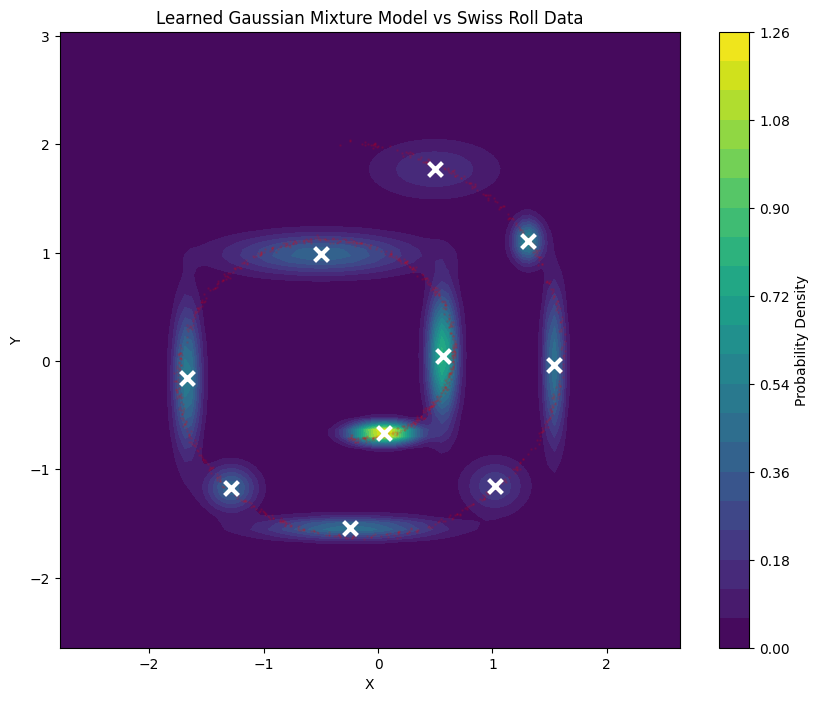

In [15]:
def plot_results(X, model):
    # Create a grid of points
    x = np.linspace(X[:, 0].min().item() - 1, X[:, 0].max().item() + 1, 100)
    y = np.linspace(X[:, 1].min().item() - 1, X[:, 1].max().item() + 1, 100)
    xx, yy = np.meshgrid(x, y)
    grid_points = torch.FloatTensor(np.column_stack([xx.ravel(), yy.ravel()]))
    
    # Evaluate log probability on grid
    with torch.no_grad():
        components, mixing_coeffs = model.get_mixture_distribution()
        component_likelihoods = torch.stack([comp.log_prob(grid_points) for comp in components])
        logits = component_likelihoods + torch.log(mixing_coeffs.unsqueeze(1))
        log_prob = torch.logsumexp(logits, dim=0)
        prob = torch.exp(log_prob).reshape(100, 100)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, prob.numpy(), levels=20)
    plt.colorbar(label='Probability Density')
    plt.scatter(X[:, 0], X[:, 1], c='red', alpha=0.1, s=1)
    
    # Plot component means
    means = model.means.detach().numpy()
    plt.scatter(means[:, 0], means[:, 1], c='white', marker='x', s=100, linewidths=3)
    
    plt.title('Learned Gaussian Mixture Model vs Swiss Roll Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Plot the results
plot_results(X, model)

shape of X: torch.Size([1000, 2])
shape of recon_data: (1000, 2)


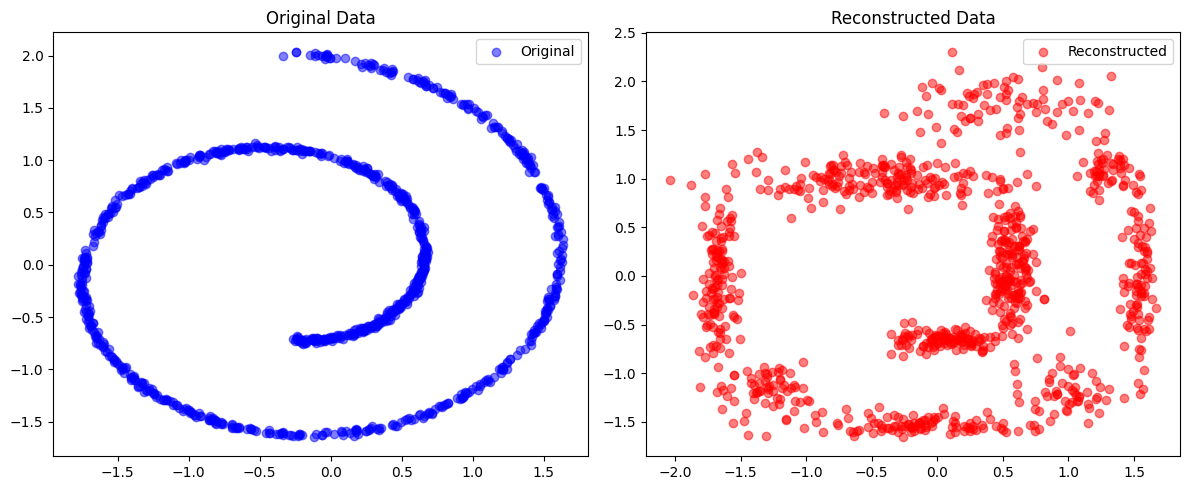

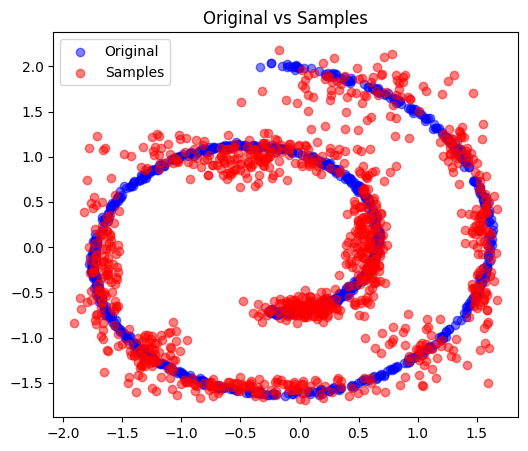

Chamfer Distance: 0.0203


In [16]:
from chamferdist import chamfer_distance

model.eval()
with torch.no_grad():
    # Get reconstructions
    recon_data = model.reconstruct(X)
    recon_data = recon_data.numpy()

# get samples
with torch.no_grad():
    samples = model.sample(1000)
    samples = samples.numpy()


# Visualization functions
def plot_original_vs_reconstructed():
    print(f"shape of X: {X.shape}")
    print(f"shape of recon_data: {recon_data.shape}")
    with torch.no_grad():
        
        # Plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(121)
        plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
        plt.title('Original Data')
        plt.legend()
        
        plt.subplot(122)
        plt.scatter(recon_data[:, 0], recon_data[:, 1], c='red', alpha=0.5, label='Reconstructed')
        plt.title('Reconstructed Data')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


def plot_original_vs_samples():
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(samples[:, 0], samples[:, 1], c='red', alpha=0.5, label='Samples')
    plt.title('Original vs Samples')
    plt.legend()
    plt.show()


plot_original_vs_reconstructed()
plot_original_vs_samples()

# compute chamfer distance
cd = chamfer_distance(X.cpu().numpy(), samples)
print(f"Chamfer Distance: {cd.item():.4f}")